# Dans ce notebook le calcul des barycentre est réalisé au moyen de la méthode proposée par M. Cuturi dans sont article "Fast computation of Wasserstein Barycenters".

In [1]:
# Imports

#Basics
import numpy as np 
import pandas as pd
import scipy.io
import time
from PIL import Image
import random
import matplotlib.pyplot as plt

#Dataset
mat = scipy.io.loadmat('centers_MNIST.mat')
tableau = mat['affNISTdata'][0][0]
#pics parameters:
nb_pixel_side = 40  
resolution = nb_pixel_side * nb_pixel_side

### Implementing Sinkholn

Let's start with a basic example in 1D.

I, first, artificially build a distance matrix:

In [590]:
# Distance matrix
n = 10
M = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        M[i,j] = abs(i-j)

a and b are the probabilities associated to X and Y, which have the distane matrix as M.

b is the target probability, while a is just initialized below:

In [587]:
# Test
b = np.ones(10) * 0.01
a = np.zeros(10)
b[0] = b[0] + 0.5
a[1] = 0.3
a[2] = 0.7
b[3] = b[3] + 0.4

In [588]:
b

array([0.51, 0.01, 0.01, 0.41, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [589]:
a

array([0. , 0.3, 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

Approximation of the transport plan leads to the subsequent approximation of the wasserstein distance

In [6]:
#Approximation: 
0.3 + 0.21*2+0.41+0.01*(1+2+3+4+5+6+7+8)

1.4899999999999998

### Let's get the Sinkhorn method coded:

According to 'Fast Computation Wasserstein Barycenters"

In [17]:
# Hyperparameters
lambda_sinkhorn = 9
iterations = 20

def sinkhorn_descent(a, b, M, lambda_sinkhorn=9, iterations=20):
    """
    lambda and iterations are hyperparameters, 
    iterations could be replaced with a stopping criterion in the futur
    """
    # Exponential of distances
    K = np.exp(-lambda_sinkhorn * M)

    #Remove zeros in a to avoid division by zeros is PRIMORDIAL :
    n = len(a)
    I = a > 0
    a = a[I]
    M = M[I,:]
    K = K[I,:]

    # Reshape b to make it a matrix if it s just one list
    if len(np.shape(b)) == 1:
        b = np.reshape(b,(len(b),1))

    K_tild = np.diag(np.reciprocal(a)) @ K

    #initialisation of u, an (n x 1) matrix, with
    n_no_null = len(a)
    u = np.ones((n_no_null,1))

    # Iterate for u
    # FIXME : should I use a stopping criteria ?
    for i in range(iterations):
        inv_u = K_tild @ (b * np.reciprocal(K.T @ u))
        u = np.reciprocal(inv_u)

    # Get v from u
    v = b * np.reciprocal( K.T @ u )

    # Get alpha, the subgradient of the Sinkhorn distance
    alpha = np.zeros((len(I),np.shape(b)[1]))
    alpha_I = -1/lambda_sinkhorn * np.log(u) + 1/(n_no_null * lambda_sinkhorn) * sum(np.log(u)) * np.ones((n_no_null,1))
    alpha[I,:] = alpha_I
    
    #Get T, the transport matrix
    T = np.zeros(np.ones(M.shape))  #modified from (len(I),len(I))
    u_flat = np.reshape(u,(len(u),)) #needed to use np.diag
    v_flat = np.reshape(v,(len(v),)) #needed to use np.diag
    T_I = np.diag(u_flat) @ K @ np.diag(v_flat)
    T[I,:] = T_I

    # Sinkhorn distance ~ Wasserstein distance
    D_S = np.trace(M.T  @ T_I)
    
    # Output: the subgradient, the transport matrix, the distance
    return(alpha, T, D_S)

The transport plan associated with our example is the following

In [592]:
T = sinkhorn_descent(a, b, M)[1]
np.round(T, 2)

array([[0.29, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.22, 0.  , 0.01, 0.41, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [593]:
D_S = sinkhorn_descent(a, b, M)[2]
D_S

1.4099933755240024

Awesome, this is close to our approximation !! The difference can be explained with the transport plan T.

In [595]:
for lambda_sink in [1, 2, 5, 9, 10, 11, 20]:
    res = sinkhorn_descent(a, b, M, lambda_sink, 30)
    T = res[1]
    D_S = res[2]
    print(f"for lambda = {lambda_sink}, the transport plan is : ")
    print(np.round(T,2))
    print('and the associated distance')
    print(np.round(D_S,2))

for lambda = 1, the transport plan is : 
[[0.24 0.   0.   0.04 0.   0.   0.   0.   0.   0.  ]
 [0.27 0.01 0.01 0.37 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.52
for lambda = 2, the transport plan is : 
[[0.28 0.01 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.23 0.   0.01 0.4  0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.43
for lambda = 5, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.01 0.41 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.41
for lambda = 9, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.01 0.41 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.41
for lambda = 10, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.01 0.41 0.01 0.01 0.01 0.01 0.01 0.01]]
and the associated distance
1.41
for lambda = 11, the transport plan is : 
[[0.29 0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]

Be sure u converges, if else, T could not be the correct transport plan and respect the joint proba

This is interesting to see, that for too big lambda, the problem is not resolved since the sum along the i axis does not match the value of the ponderation of a !!

# Let's test with MNIST data

In [2]:
# Number of samples
N_samples = len(tableau[2][0])

# Samples are 40x40 = 1600 length arrays that represent digits in grey scale
pixels = [np.array([a[i] for a in tableau[2]]) for i in range(N_samples)]
atoms = [p/sum(p) for p in pixels] 

# Each array is labelled
int_0_9 = tableau[5][0]

# Dataframe to store the arrays and the labels:
df_digits = pd.DataFrame({'pixels':pixels, 'int_0_9':int_0_9, 'atoms':atoms})
df_digits.head(3)

,pixels,int_0_9,atoms
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Let's build the matrix of distances between digit data:

In [3]:
# Picture resolution 
resolution = nb_pixel_side * nb_pixel_side

## Get M the squared Euclidean distance Matrix between all 40x40 pixels
# To make sure I don't mess up indexing things, I'll set up a list of locations and reshape it into a matrix
# So when I calculate a pairwise distance in the matrix, I can easily associate it to the location in the vector
locations_vec = np.array(range(resolution))
locations_arr = np.reshape(locations_vec, (nb_pixel_side,nb_pixel_side))

M = np.zeros((resolution,resolution))
# Having 4 "for" loops is a bit embarassing, but I'm not trying to think too hard right now
for i1 in range(nb_pixel_side):
    for j1 in range(nb_pixel_side):
        for i2 in range(nb_pixel_side):
            for j2 in range(nb_pixel_side):
                M[locations_arr[i1,j1], locations_arr[i2,j2]] = np.sqrt((i1-i2)**2 + (j1-j2)**2)
            

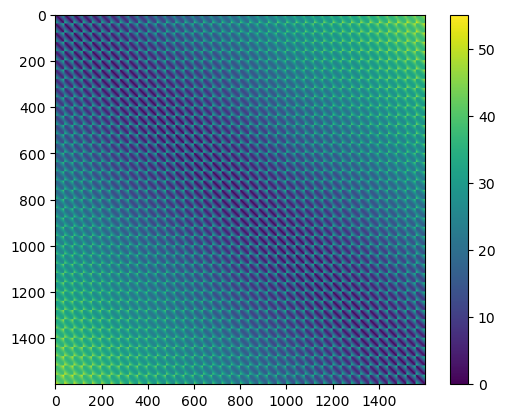

In [14]:
# The plot looks reasonable
plt.imshow(M)
plt.colorbar()
plt.show()

In [34]:
# Number of data
N = 100

# Working data
df_work = df_digits.iloc[:100].sort_values('int_0_9').reset_index()

D = np.zeros((N,N))
for i in range(N):
    a = df_work.atoms[i]
    for j in range(N):
        b = df_work.atoms[j]
        D[i,j] = sinkhorn_descent(a, b, M, 9,1)[2]

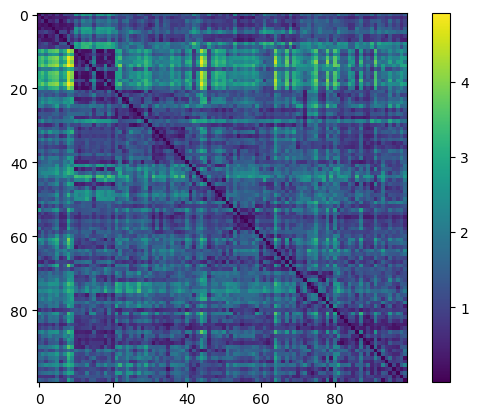

In [35]:
# Plot them
plt.imshow(D)
plt.colorbar()
plt.show()

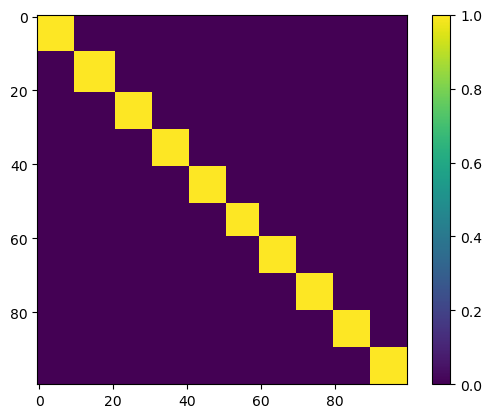

In [36]:
# Compare to when the digits are equal
B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = (df_work.int_0_9[i] == df_work.int_0_9[j])

plt.imshow(B)
plt.colorbar()
plt.show()

This looks convincing

Let's try to compare equal numbers :

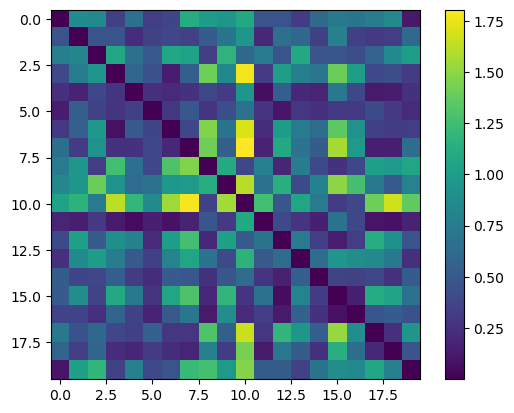

In [293]:
# Number of data
N = 20

# Working data
df_zeros = df_digits.loc[df_digits.int_0_9 == 0].reset_index()
df_work = df_zeros.iloc[:N]

D = np.zeros((N,N))
for i in range(N):
    a = df_work.atoms[i]
    for j in range(N):
        b = df_work.atoms[j]
        D[i,j] = sinkhorn_descent(a, b, M, 9,1)[2]
        
# Plot 
plt.imshow(D)
plt.colorbar()
plt.show()

I would have thought that the distance between the six be homogeneously smaller.

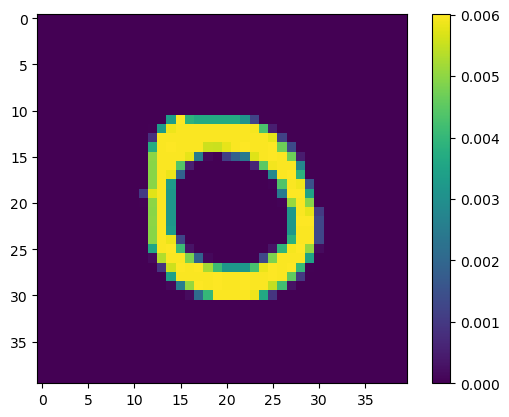

In [294]:
img = np.reshape(df_work.atoms[15], (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

In [40]:
sinkhorn_descent(a, b, M, lambda_sink)[1].shape


(1600, 1600)

## Let's try a regularized gradient descent

Let's find a digit with gradient descent:

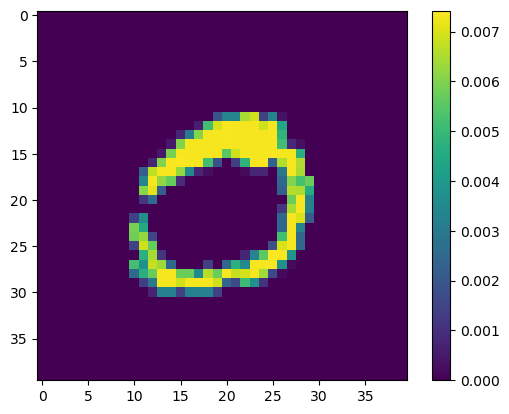

In [581]:
b = df_digits.atoms.iloc[25]
img = np.reshape(b, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

In [582]:
# Initialisation
steps = 100
a = np.ones(resolution) / resolution
# Keep track
A = np.zeros((resolution,steps+1))
A[:,0] = a


eta = 10**-4

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 20)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)
    # Save it
    A[:,i+1] = a

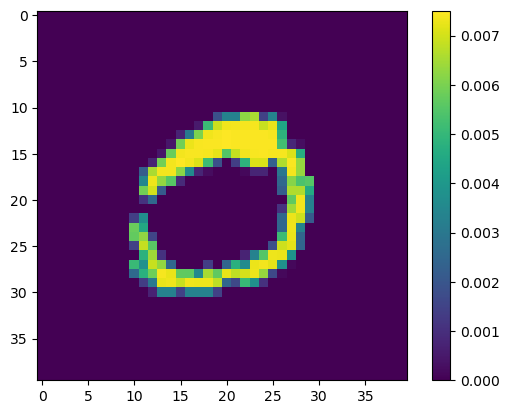

In [583]:
i = 100
img = np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

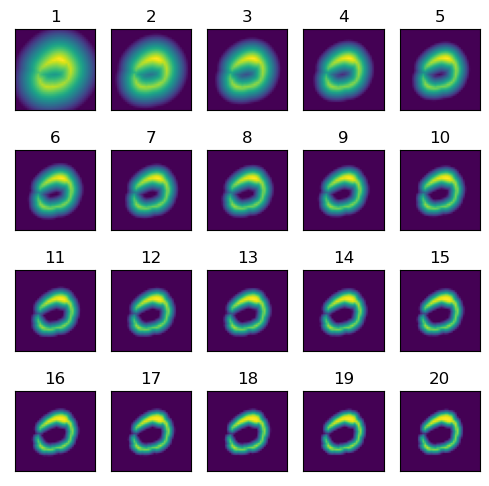

In [584]:
## Plot iterates

# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(6,6))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side))) #, vmin=0, vmax=0.001)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

This is awesome !

The two following calculations show that modifying the eta at the right time increases the convergence speed.

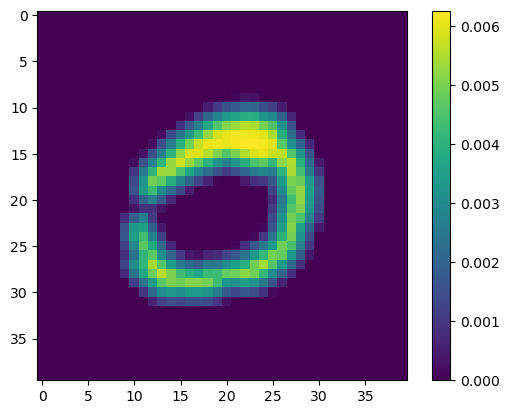

In [585]:
# Initalisation
a = np.ones(resolution) / resolution

# parameters
steps = 20
eta = 10**-4

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 20)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)

img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

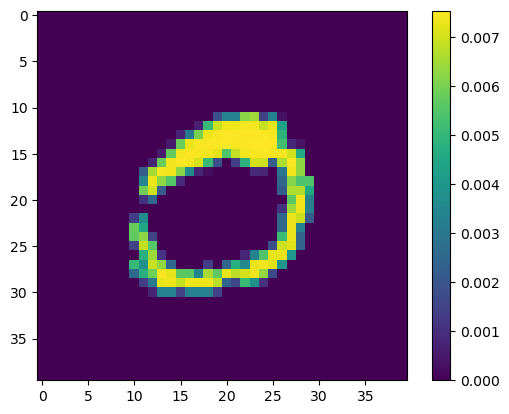

In [314]:
# Initalisation
a = np.ones(resolution) / resolution

# parameters
steps = 10
eta = 10**-3

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 20)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)
    
# new parameters
steps = 10
eta = 10**-4

for i in range(steps):
    # Gradient
    alpha = sinkhorn_descent(a, b, M, 10, 20)[0]
    # Reformat to match shape of r and move opposite that direction
    a = a + eta * np.reshape(alpha,np.shape(a))
    # Keep it nonnegative and unit mass
    a = a * (a>0)
    a = a / sum(a)

img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()


#### Final remarks:
FIXME: once a pixel value is set to zero it never comes back, that is not ideal

Here are some more thoughts:
- Adding noise to things can remove the zero entries and is probably good enough
 - Maybe if I treat division by zero as $+\infty$ then things work out?? I doubt it though
- For speed: check how much faster Regularized Sinkhorn is than Sharp Sinkhorn, since it could help to use the former for the first few iterations for speed (Diffy Sink p. 12 does this)

## Algorithm 1 :  Fast Computation of Wasserstein Barycenters - M. Cuturi

Let's try to get the barycenters of N digits with the gradient descent explained in the Cuturi's paper.

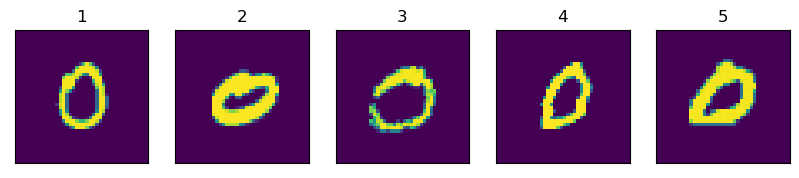

In [520]:
# Number of digits
N = 5

# List of probabilities
b = list( df_digits.loc[df_digits.int_0_9 == 0].reset_index().atoms.iloc[:N] )

# Visualisation
# Set up the axes
fig, axs = plt.subplots(1,N,figsize=(10,10))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i-1], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

In [14]:
# Definition of the proximal mapping and proximal updates
# As applied in the Cuturi's paper
def prox_map(a1, alpha, beta, t0):
    a1 = a1 * np.exp(- t0 * beta * alpha)
    a1 = a1 / sum(a1)
    return(a1)

In [10]:
# Algorithm 1
def Kullback_descent(a, b, M, steps1, t, t0, lambda_sinkhorn=10, iterations=20):
    # Keep track
    A = np.zeros((len(a),steps1+1))
    A[:,0] = a
    a1 , a2 = a , a
    for i in range(steps1):
        # Learning rate
        beta = (t + 1) / 2
        # Learning 
        a = (1 - 1/beta) * a1 + a2 / beta

        # Subgradient of the sum of the primal problems
        alpha = np.ones(np.shape(a))
        for k in range(len(b)):
            alpha_k = sinkhorn_descent(a, b[k], M, lambda_sinkhorn, iterations)[0]
            alpha_k = np.reshape(alpha_k,np.shape(a))
            alpha = alpha + alpha_k
        alpha = alpha / len(b)

        # Gradient descent, known as the Bregman descent, 
        # used in the Kullback-Leibler case:
        a1 = prox_map(a1, alpha, beta, t0)

        # definition of a2
        a2 = (1 - 1/beta) * a2 + a1 / beta
        
        # reduce the learning rate
        t = t + 1

        # Keep track
        A[:,i+1] = a2

    # Output
    return(a, A)

Application where digits are zeros:

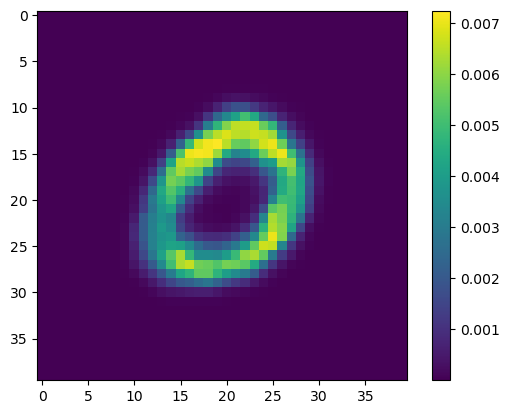

In [552]:
# Initalisation
steps1 = 100
a = np.ones(resolution) / resolution

# Tunes the learning rate beta
t = 0

# length of the step along the gradient direction
t0 = -10**-3

# Results:
res = Kullback_descent(a, b, M, steps1, t, t0)
a = res[0]

# Visualisation of the result
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

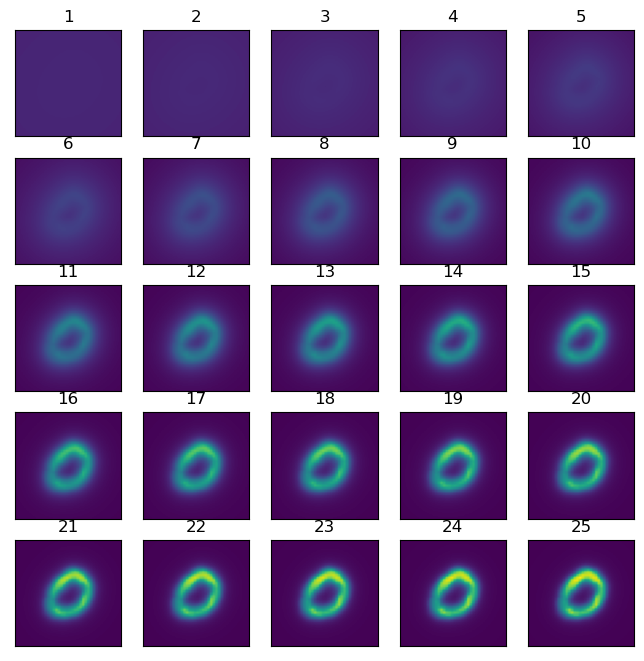

In [568]:
## Plot iterates
A = res[1]

# Set up the axes
fig, axs = plt.subplots(5,5,figsize=(8,8))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*4], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.006)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

Let's try with 3's

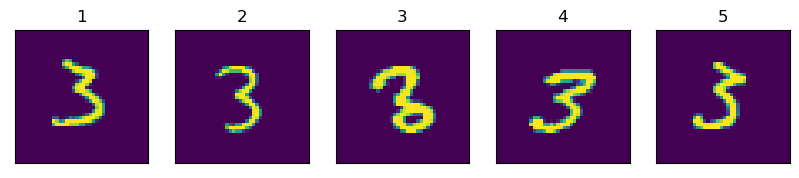

In [554]:
# Number of digits
N = 5

# List of probabilities
b = list( df_digits.loc[df_digits.int_0_9 == 3].reset_index().atoms.iloc[:N] )

# Visualisation
# Set up the axes
fig, axs = plt.subplots(1,N,figsize=(10,10))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i-1], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

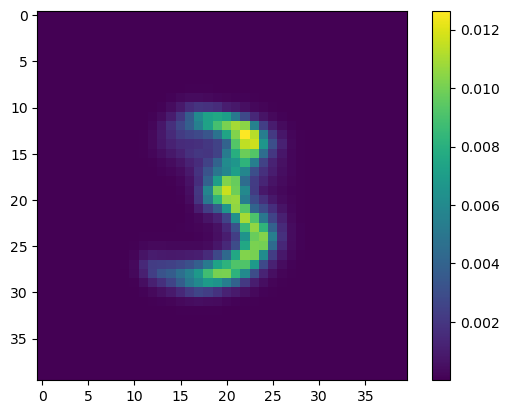

In [569]:
# Initalisation
steps1 = 100
a = np.ones(resolution) / resolution

# Tunes the learning rate beta
t = 0

# length of the step along the gradient direction
t0 = -10**-3

# Results:
res = Kullback_descent(a, b, M, steps1, t, t0)
a = res[0]

# Visualisation of the result
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

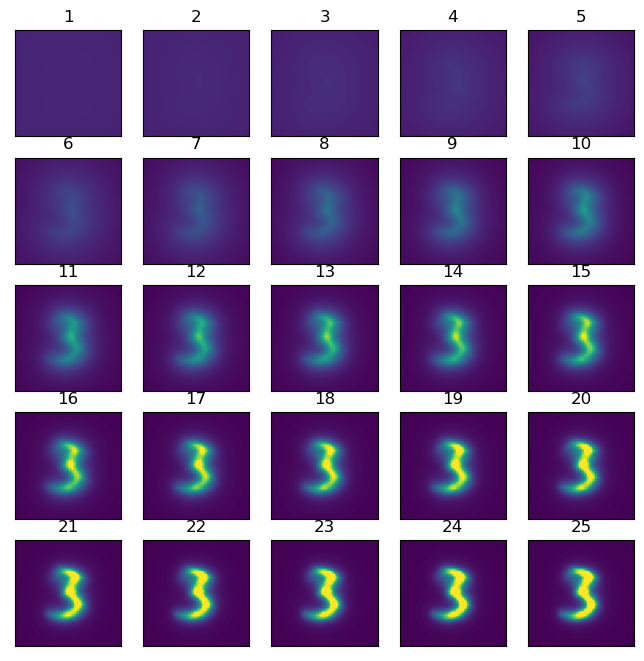

In [570]:
## Plot iterates
A = res[1]

# Set up the axes
fig, axs = plt.subplots(5,5,figsize=(8,8))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*4], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.006)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

The results are byond my expectations, the starting 3's don't look alike at all and the final result is very clean !!

Last try with the 4's because according to the Sinkhorn distance matrix computed before, these digits don't really look alike.

Indeed some 4's are closed, while other are open, I wonder what will be the shape of the result.

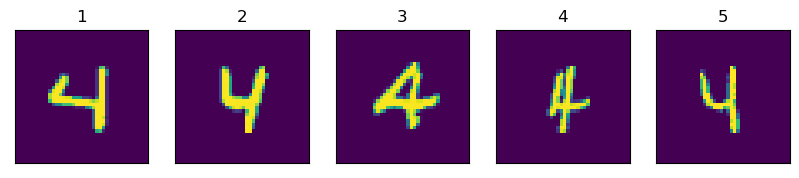

In [4]:
# Number of digits
N = 5

# List of probabilities
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:N] )

# Visualisation
# Set up the axes
fig, axs = plt.subplots(1,N,figsize=(10,10))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i-1], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

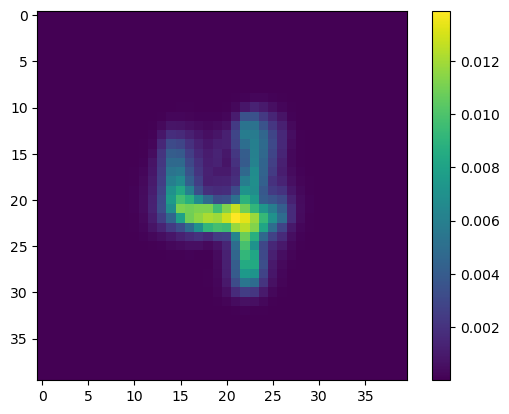

In [576]:
# Initalisation
steps1 = 100
a = np.ones(resolution) / resolution

# Tunes the learning rate beta
t = 0

# length of the step along the gradient direction
t0 = -10**-3

# Results:
res = Kullback_descent(a, b, M, steps1, t, t0)
a = res[0]

# Visualisation of the result
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

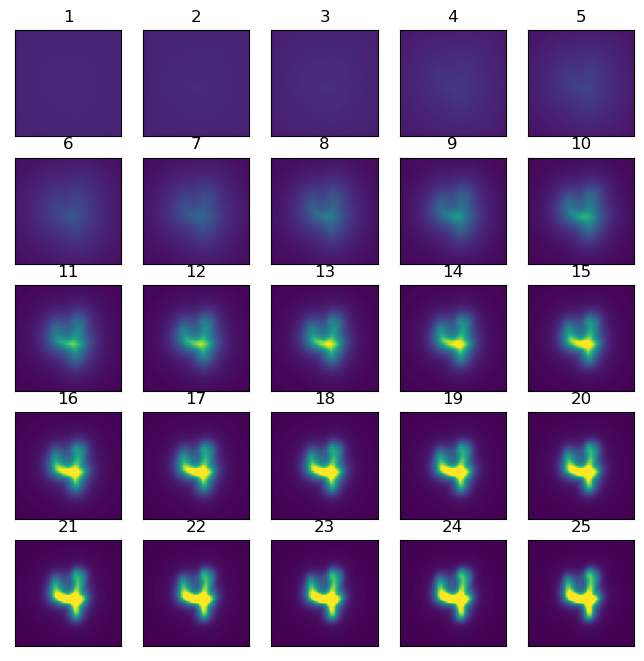

In [577]:
## Plot iterates
A = res[1]

# Set up the axes
fig, axs = plt.subplots(5,5,figsize=(8,8))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i*4], (nb_pixel_side,nb_pixel_side)), vmin=0, vmax=0.006)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

#### Conclusions:
There are some parameters that demand more attention to be tuned efficiently:
- lambda
- t0
- t (eventhaugh t = 0 looks to be a sufficient initialisation)

The code takes some time to be computed (around 40s for 100 steps -algo 1- and 20 iterations -sinkhorn gradient).

According to 'Differential Properties of Sinkhorn Approximation for Learning' (Luise), the complexity of the sinhorn gradient computation is O(n x m x lambda/epsilon²) where epsilon define the accuracy of the solution, n = len(a), m = len(b[i]).

At each iteration a becomes more and more full of zeros (thanks to the constraint that I added: a must be superior to 10**-5), let's see if that enable the method to speed up.

In [67]:
# Initalisation
steps1 = 100
a = np.ones(resolution) / resolution

# Tunes the learning rate beta
t = 0

# length of the step along the gradient direction
t0 = -10**-3

# Keep track
A = np.zeros((len(a),steps1+1))
A[:,0] = a
# Time spend at each iteration
time_spent = [0]
# Number of zeros
nb_zeros = [len([ai for ai in a if ai==0])]

# Algorithm 1
a1 , a2 = a , a
for i in range(steps1):
    start = time.time()
    # Learning rate
    beta = (t + 1) / 2
    # Learning 
    a = (1 - 1/beta) * a1 + a2 / beta

    # Subgradient of the sum of the primal problems
    alpha = np.ones(np.shape(a))
    for k in range(len(b)):
        alpha_k = sinkhorn_descent(a, b[k], M, lambda_sinkhorn, iterations)[0]
        alpha_k = np.reshape(alpha_k,np.shape(a))
        alpha = alpha + alpha_k
    alpha = alpha / len(b)

    # Gradient descent, known as the Bregman descent, 
    # used in the Kullback-Leibler case:
    a1 = prox_map(a1, alpha, beta, t0)

    # definition of a2
    a2 = (1 - 1/beta) * a2 + a1 / beta

    # reduce the learning rate
    t = t + 1

    # Keep track
    A[:,i+1] = a
    
    # Change the support when ai is too small
    a = a * (a>10**-5)
    a = a / sum(a)
    
    # Duration:
    end = time.time()
    time_spent.append(end - start)
    nb_zeros.append(len([ai/len(a) for ai in a if ai==0]))

In [66]:
np.sort(a)

array([0.00017534, 0.00018386, 0.0001856 , ..., 0.00162628, 0.00164584,
       0.00165933])

Text(0, 0.5, 'duration (s)')

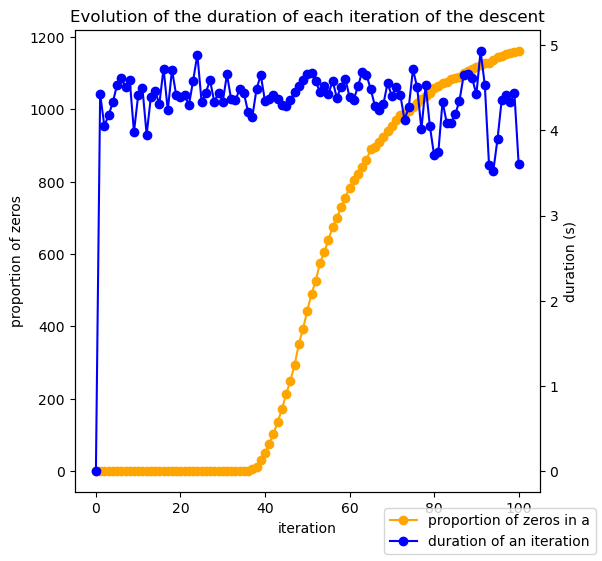

In [68]:
nb_iterations = [i for i in range(len(time_spent))]
fig, ax1 = plt.subplots(figsize=(6,6))
ax2 = ax1.twinx()

ax2.plot(nb_iterations, time_spent, '-o', color='b', label='duration of an iteration')
ax1.plot(nb_iterations, nb_zeros, '-o', color='orange', label='proportion of zeros in a')
fig.legend(loc='lower right')
plt.title('Evolution of the duration of each iteration of the descent')
ax1.set_xlabel('iteration')
ax1.set_ylabel("proportion of zeros")
ax2.set_ylabel("duration (s)")

### Let's get the support optimized

According to the Cuturi's paper, the optimization on the support is doable only in the Euclidean space. Therefore we need to translate the location of pixels in the Euclidean/canonic space for R².


The following function turn the pixel notation into canonic base notation X (Nx1) to X_can (nb_of_atoms x 2).

to_base_pixel is the inverse of to_base_can.

In [497]:
# Building of a matrix m*2 that stores the atoms of the vector X (resolution x 1):
def to_base_can(X, nb_pixel_side=40):
    # focus on the 1s:
    J = X>0
    
    # initialize
    X_can = np.zeros((sum(J==True),2))
    
    j = 0
    i = 0
    for booleen in J:
        
        # only check ones:
        if booleen:
            # along the x axis 
            abscisse = j // nb_pixel_side
            # storing
            X_can[i,0] = abscisse
            #along the y axis
            X_can[i,1] = j - abscisse * nb_pixel_side
            
            # keep track in X
            i = i + 1
        
        # keep track in J
        j = j + 1
        
    return(X_can) 

# Turn the base can into the pixel base back:
def to_base_pixel(X_can, nb_pixel_side=40):
    X = np.zeros((nb_pixel_side**2))
    for x_ij in X_can:
        loc_pix = int(x_ij[0]) * nb_pixel_side + int(x_ij[1]) 
        #and NOT " loc_pix = int(np.round(x_ij[0]) * nb_pixel_side + np.round(x_ij[1])) " that is less precise
        X[loc_pix] = 1
    return(X)

Let's check the function is working correctly

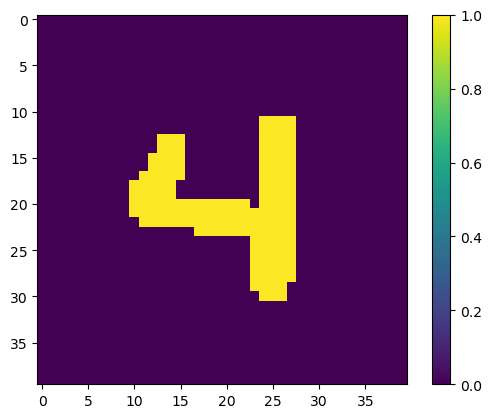

In [498]:
# List of aimed probabilities for a '4'
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:1] )

# Support of b:
Y = np.ones(resolution) * (b[0]>0)

X = Y

# Visualisation of the result
img = np.reshape(to_base_pixel(to_base_can(X)), (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

Ok perfect.

We have the transformation from pixel vectors to Euclidiean base.

### Simple gradient descent on the support according to the Cuturi's method

Let's try a simple gradient descent on the support: I take a '0' and I try to get it back in term of support.

First I generate a random support.

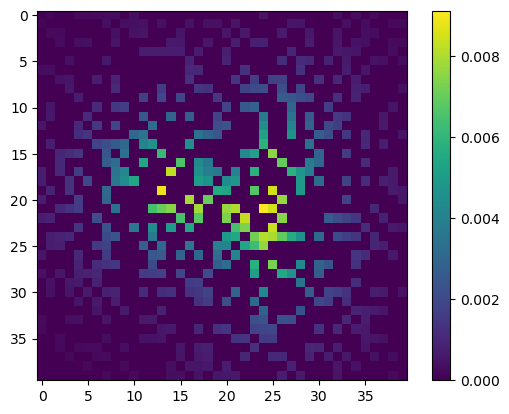

In [572]:
# List of aimed probabilities for a '4'
b = list( df_digits.loc[df_digits.int_0_9 == 4].reset_index().atoms.iloc[:1] )

# Support of b:
Y = np.ones(resolution) * (b[0]>0)

# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Kullback_descent parameters:
# Tunes the learning rate beta
t = 0
# length of the step along the gradient direction
t0 = -10**-2

# a is an optimized probability with Kullback_descent
a = X / sum(X)
a = Kullback_descent(a, b, M, 10, t, t0)[0]
img = np.reshape(a, (nb_pixel_side,nb_pixel_side))
plt.imshow(img)
plt.colorbar()
plt.show()

This is a visualisation of a on the initial support X and the probability a once it is optimized thanks to the Kullback_descent.

In [573]:
# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Initialisation
steps2 = 20
theta = 0.2

# Keep track
# in support
l_X = np.zeros((resolution,steps2+1))
l_X[:,0] = X
# in probabilities
A = np.zeros((resolution,steps2+1))

#gradient descent:
for i in range(steps2):
    
    # initialisation
    a = X / sum(X)
    # Kullback descent
    a = Kullback_descent(a, b, M, 15, t, t0)[0]
    # keep track
    A[:,i] = a
    
    #sinkhorn_descent to get T and the gradient for X
    I_X = X>0
    I_Y = Y>0
    T_pix = sinkhorn_descent(a, b[0], M)[1]
    # selection of the lines and colums of interest
    T_pix = T_pix[I_X,:] # in term of X
    T_pix = T_pix[:,I_Y] # in term of Y
    # In the euclidean space
    YT = to_base_can(Y).T @ T_pix.T

    # Gradient:
    grad = YT @ np.diag(a[I_X]**-1)
    
    # X to Euclidean base:
    X = to_base_can(X)
    
    # Learning of X in the EUCLIDEAN SPACE:
    X = (1 - theta) * X + theta * grad.T

    # Back to the pixel base (to perform a on this new support on the next step)
    X = to_base_pixel(X)
    
    # Keep track
    # back to the pixel space
    l_X[:,i] = X


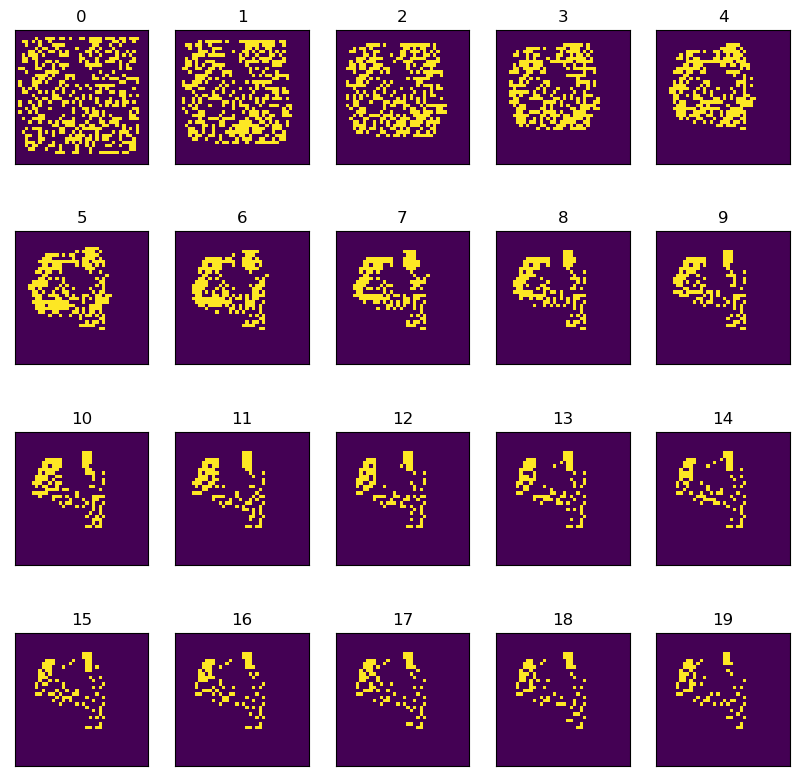

In [574]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side))) #, vmin=0.86, vmax=0.93)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

It is intersting to note that less and less pixels are used iteration after iteration. That is because the gradient follows the direction of the greater probabilities location. In other words, the pixels are superimposed on the same location. 

In fact after the 10th iteration, the support is not improving that much.
Maybe add a stopping criteria would do the work.

FIXME: add a stopping criteria

Text(0, 0.5, 'number of pixels')

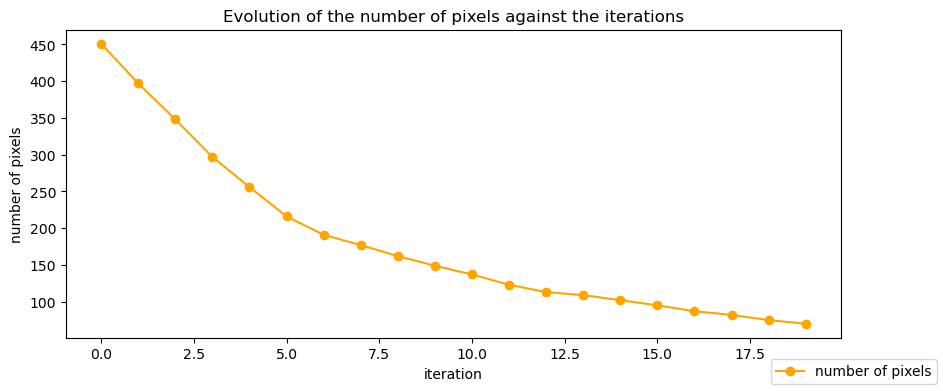

In [533]:
nb_pixels = [len(to_base_can(l_X[:,i])) for i in range(steps)]
nb_iterations = [i for i in range(steps)]
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(nb_iterations, nb_pixels, '-o', color='orange', label='number of pixels')
fig.legend(loc='lower right')
plt.title('Evolution of the number of pixels against the iterations')
ax1.set_xlabel('iteration')
ax1.set_ylabel("number of pixels")

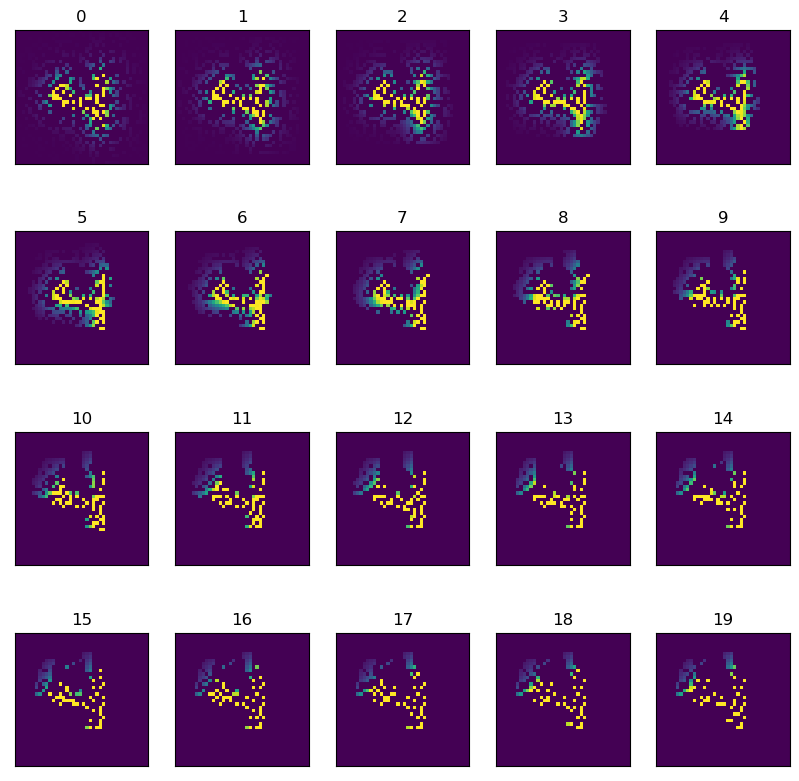

In [575]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

## Cuturi whole algorithm (algorithm 2 cf Cuturis paper)

In [616]:
# This algorithm is presented as 'algorithm 2' in the paper 'Fast Computation of Wasserstein Barycenters' by Cuturi
def Cuturi_support_proba(X, b, Y, M, theta=0.2, steps2=20, t=0, t0=-10**-2):
    # Keep track
    # in support
    l_X = np.zeros((resolution,steps2+1))
    # in probabilities
    A = np.zeros((resolution,steps2+1))
    # gradient:
    G = np.zeros((resolution,steps2+1))

    m = len(b)
    #gradient descent:
    for i in range(steps2):

        # initialisation
        a = X / sum(X)
        # Kullback descent
        a = Kullback_descent(a, b, M, 15, t, t0)[0]
        # keep track
        A[:,i] = a

        #sinkhorn_descent to get T and the gradient for X
        I_X = X > 0
        # X to Euclidean base:
        X = to_base_can(X)

        #sinkhorn_descent to get T and the gradient for X
        grad = np.zeros(X.shape)
        for j in range(m):
            I_Y = Y[j] > 0
            T_pix = sinkhorn_descent(a, b[j], M)[1]
            # selection of the lines and colums of interest
            T_pix = T_pix[I_X,:] # in term of X
            T_pix = T_pix[:,I_Y] # in term of Y
            # In the euclidean space
            TY = T_pix @ to_base_can(Y[j])

            # Gradient (times m):
            grad = grad + np.diag(a[I_X]**-1) @ TY
        grad = grad / m

        # Learning of X in the EUCLIDEAN SPACE:
        X = (1 - theta) * X + theta * grad 

        # Back to the pixel base (to perform a on this new support on the next step)
        X = to_base_pixel(X)

        # Keep track
        # back to the pixel space
        l_X[:,i] = X
        # grad
        G[:,i] = to_base_pixel(grad)
        
    # Output:
    return(X, a, l_X, A, G)

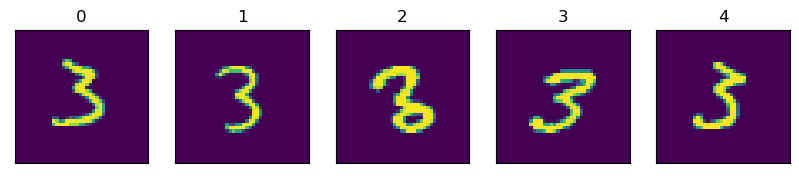

In [618]:
# Input
m = 5
# List of aimed probabilities for a '0'
b = list( df_digits.loc[df_digits.int_0_9 == 3].reset_index().atoms.iloc[:m] )

# Supports of b's:
Y = [np.ones(resolution) * (b[i]>0) for i in range(m)]

# X is a random image with 500 white pixels
X = np.zeros(resolution)
X[:500] = 1
np.random.shuffle(X)

# Visualisation of the inputs
# Set up the axes
fig, axs = plt.subplots(1,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(b[i], (nb_pixel_side,nb_pixel_side)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

In [604]:
# Output
res = Cuturi_support_proba(X, b, Y, M, theta=0.1, steps2=20)
l_X = res[2]
A = res[3]
G = res[4]

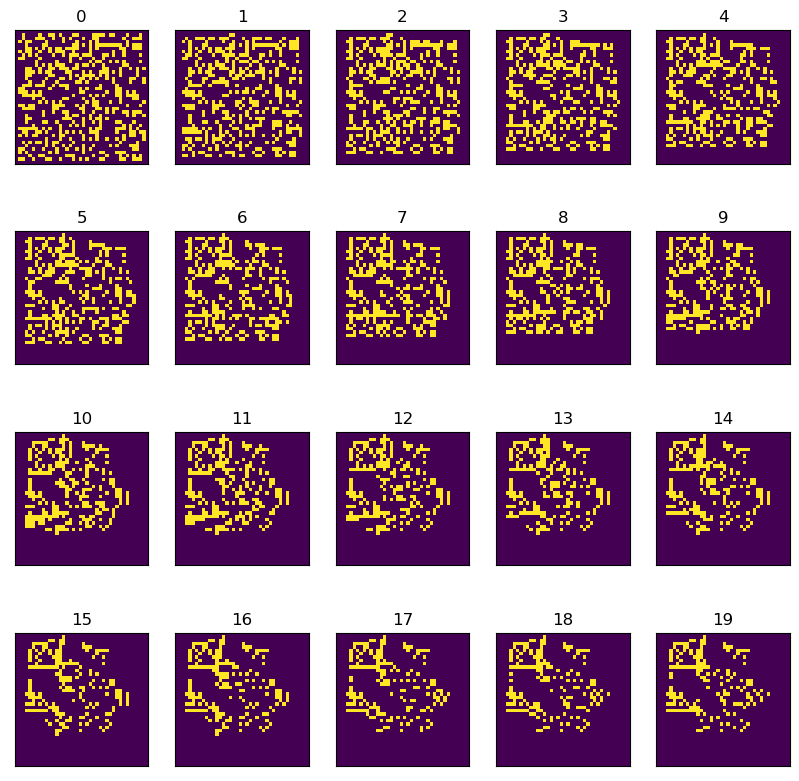

In [605]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

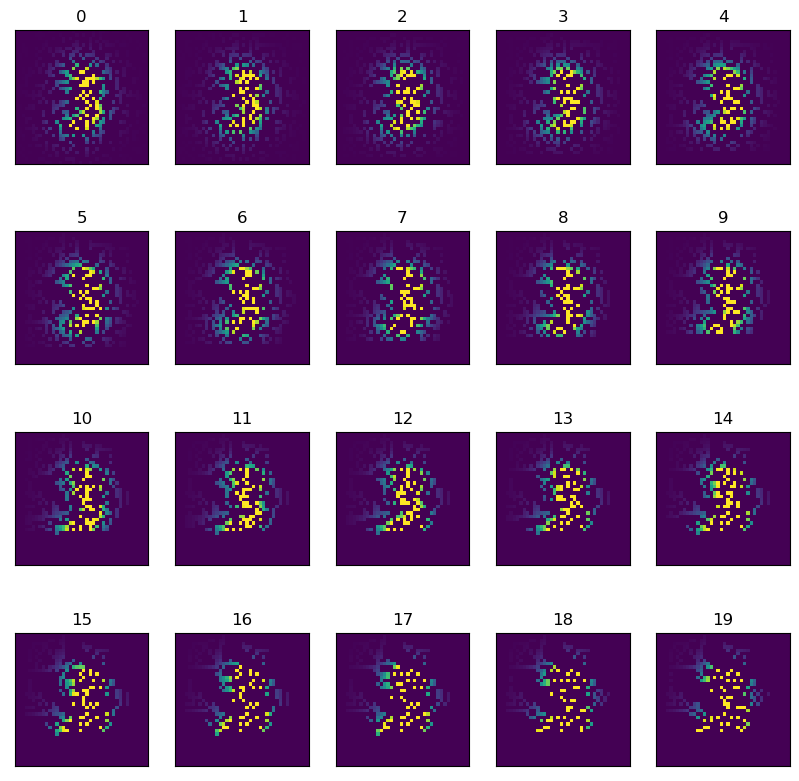

In [606]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

In [607]:
# Output
res = Cuturi_support_proba(X, b, Y, M, theta=0.01, steps2=20)
l_X = res[2]
A = res[3]
G = res[4]

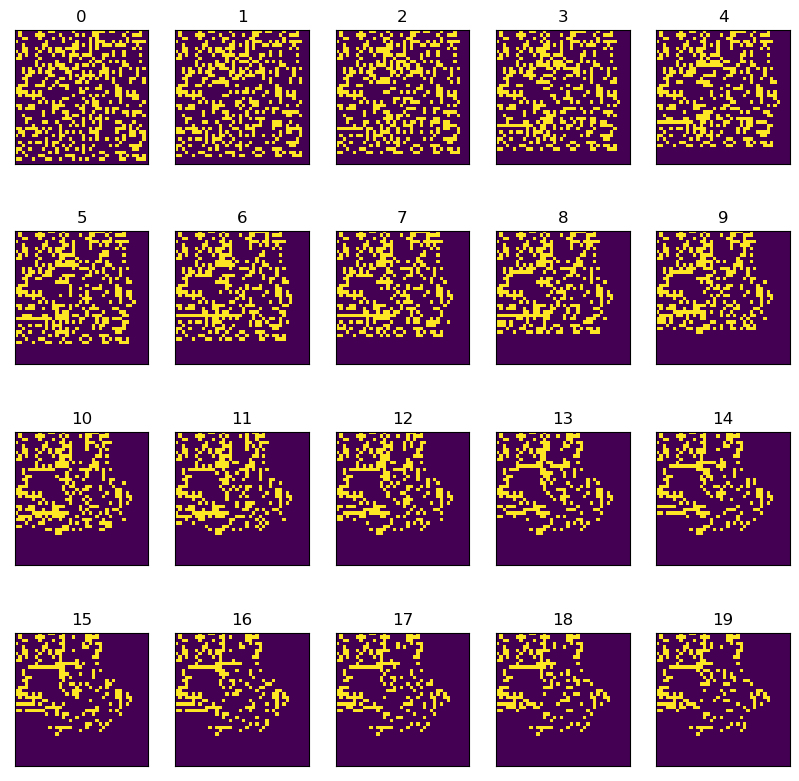

In [608]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

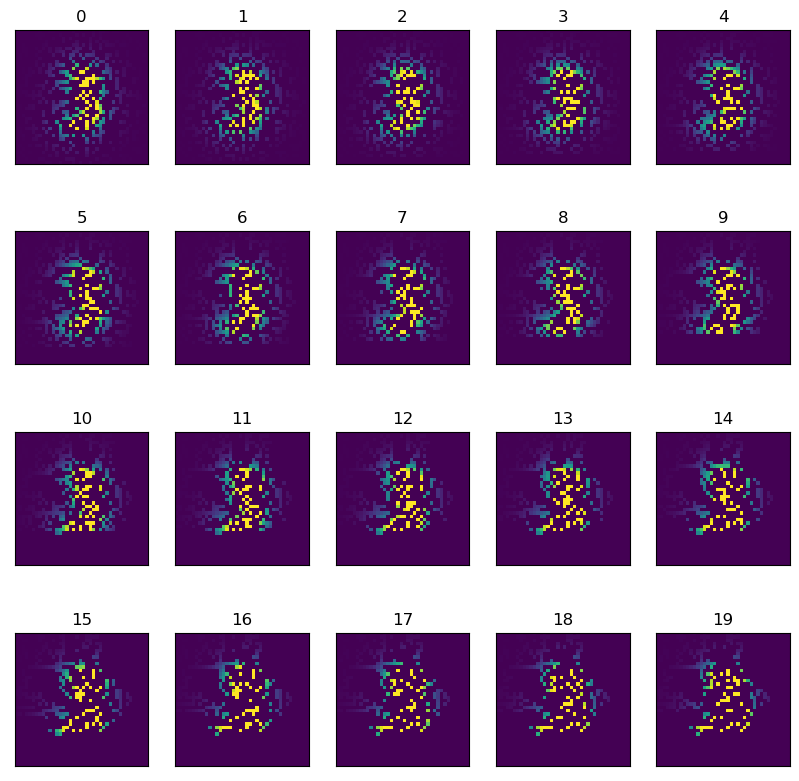

In [609]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

In [610]:
# Output
res = Cuturi_support_proba(X, b, Y, M, theta=0.2, steps2=20)
l_X = res[2]
A = res[3]
G = res[4]

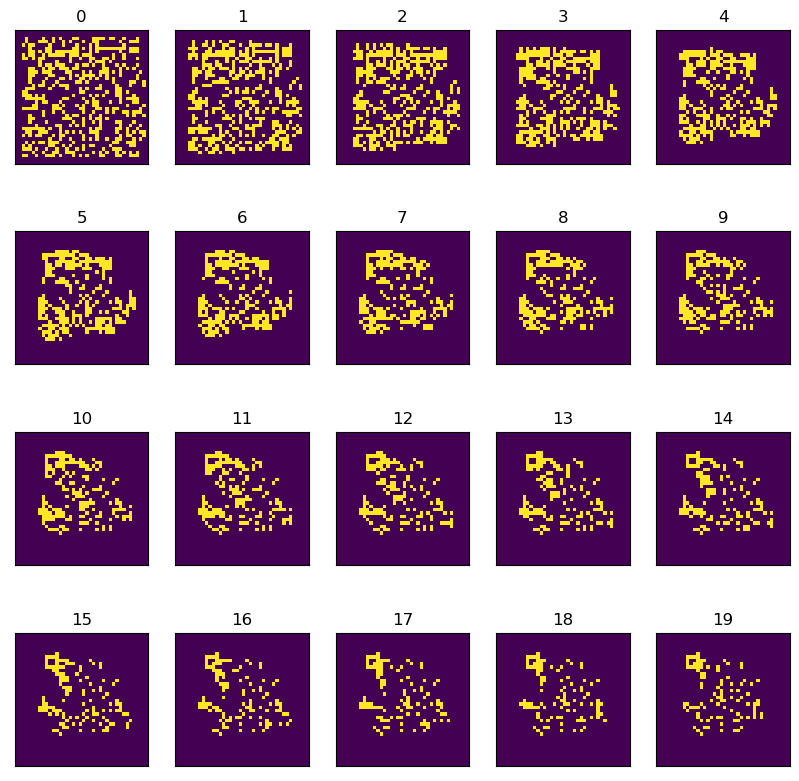

In [611]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

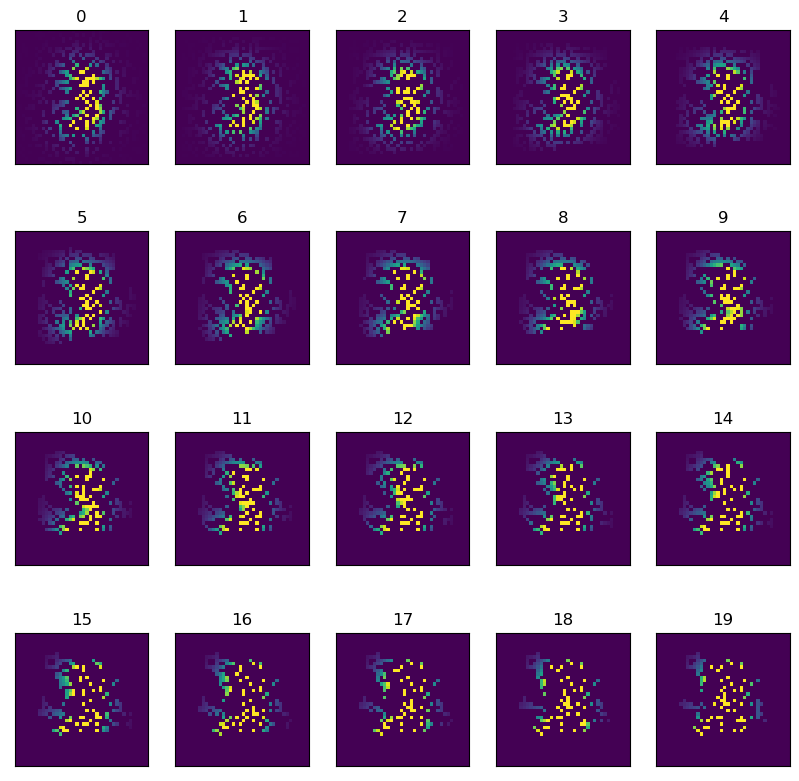

In [612]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

Let's try with a good support as we initialize X.

In [635]:
# Output
X1 = Y[1]
res = Cuturi_support_proba(X1, b, Y, M, theta=0.2, steps2=20)
l_X = res[2]
A = res[3]
G = res[4]

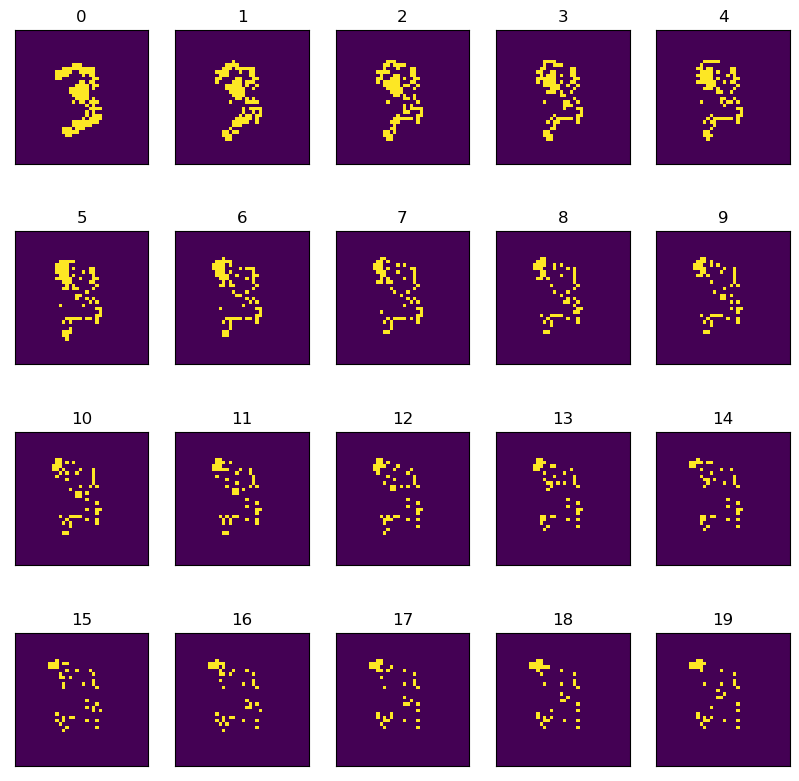

In [636]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(l_X[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

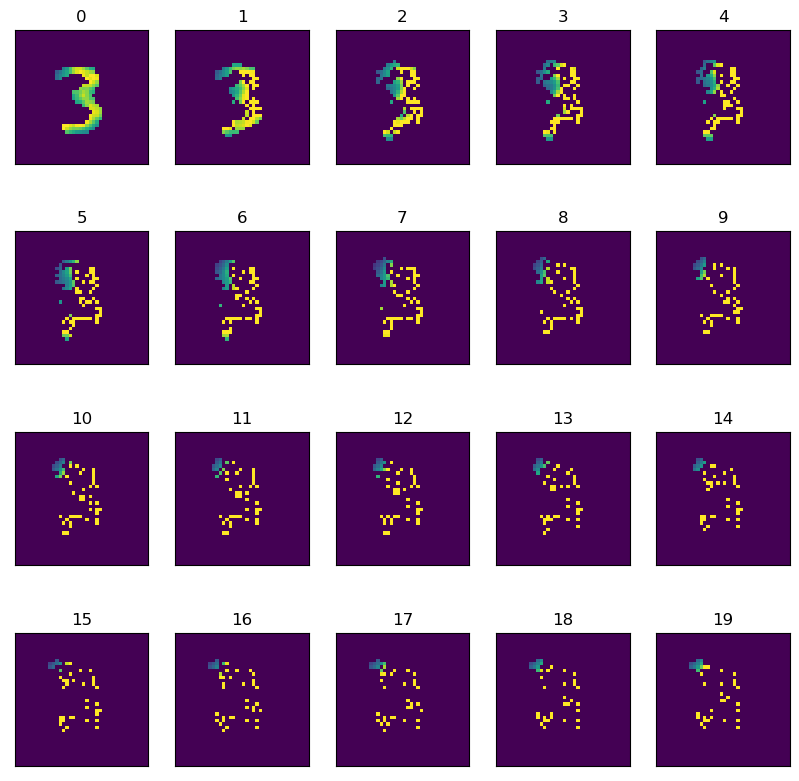

In [637]:
# Visualisation of the results
# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(10,10))

# Iterate over the plotting locations
i = -1
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(A[:,i], (nb_pixel_side,nb_pixel_side)), vmin=0.0, vmax=0.01)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

## Conclusion for the support optimisation:

It is complicated to be satisfied with this optimisation.
When only 1 digit is computed the algorithm is able to find his way through the almost correct position, but because of the to_base_can function some pixels are never reached.

The approximation of the gradient could be also a source of mistake. 
FIXME: Playing with the parameter theta could be a source of solution ?